In [1]:
import pandas as pd
import numpy as np

In [2]:
class MobilityDataAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None

    def load_data(self):
        #loaded limited number of rows for testing
        self.df = pd.read_csv(self.file_path)
        return self.df

    def clean_data(self):
        if self.df is None:
            raise ValueError("data not loaded")

        df = self.df.copy()

        #converted pickup and dropoff to datetime
        df['tpep_pickup_datetime'] = pd.to_datetime(
            df['tpep_pickup_datetime'],
            errors='coerce'
        )

        df['tpep_dropoff_datetime'] = pd.to_datetime(
            df['tpep_dropoff_datetime'],
            errors='coerce'
        )

        #dropped rows with invalid timestamps
        df = df.dropna(subset=[
            'tpep_pickup_datetime',
            'tpep_dropoff_datetime'
        ])

        #removed logically invalid trips
        df = df[df['tpep_dropoff_datetime'] >= df['tpep_pickup_datetime']]

        #handled passenger count
        df['passenger_count'] = pd.to_numeric(
            df['passenger_count'],
            errors='coerce'
        )

        df['passenger_count'] = df['passenger_count'].fillna(
            df['passenger_count'].median()
        )

        df = df[df['passenger_count'] > 0]

        #handled trip distance
        df['trip_distance'] = pd.to_numeric(
            df['trip_distance'],
            errors='coerce'
        )

        df = df[df['trip_distance'] > 0]

        #converted monetary columns
        money_cols = [
            'fare_amount',
            'extra',
            'mta_tax',
            'tip_amount',
            'tolls_amount',
            'improvement_surcharge',
            'total_amount'
        ]

        for col in money_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        df[money_cols] = df[money_cols].fillna(0)

        self.df = df
        return self.df

    def feature_engineering(self):
        if self.df is None:
            raise ValueError("data not cleaned")

        #created hour feature
        self.df['pickup_hour'] = self.df['tpep_pickup_datetime'].dt.hour

        #created day of week feature
        self.df['pickup_day_of_week'] = self.df['tpep_pickup_datetime'].dt.dayofweek

        #created month feature
        self.df['pickup_month'] = self.df['tpep_pickup_datetime'].dt.month

        #created quarter feature
        self.df['pickup_quarter'] = self.df['tpep_pickup_datetime'].dt.quarter

        return self.df


In [3]:
#initialized analyzer with local file
analyzer = MobilityDataAnalyzer(
    file_path=r"D:\\Downloads\\yellow_tripdata_2015-01.csv"
)

#loaded data
df = analyzer.load_data()

#cleaned data
df = analyzer.clean_data()

#engineered features
df = analyzer.feature_engineering()

#checked datatypes
df.dtypes


VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
RateCodeID                        int64
store_and_fwd_flag               object
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
pickup_hour                       int32
pickup_day_of_week                int32
pickup_month                      int32
pickup_quarter                    int32
dtype: object

In [4]:
df.to_csv("cleaned_yellow_tripdata.csv", index=False)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#total revenue
total_revenue = df['total_amount'].sum()

#monthly revenue
monthly_revenue = (
    df.groupby('pickup_month')['total_amount']
      .sum()
      .reset_index(name='monthly_revenue')
)

#average trip distance
avg_trip_distance = df['trip_distance'].mean()

#average fare per trip
avg_fare = df['fare_amount'].mean()

#tip percentage per trip
df['tip_percentage'] = np.where(
    df['fare_amount'] > 0,
    (df['tip_amount'] / df['fare_amount']) * 100,
    0
)

#average tip percentage
avg_tip_percentage = df['tip_percentage'].mean()

#trips per hour
trips_per_hour = (
    df.groupby('pickup_hour')
      .size()
      .reset_index(name='trip_count')
)

#revenue per mile
df['revenue_per_mile'] = np.where(
    df['trip_distance'] > 0,
    df['total_amount'] / df['trip_distance'],
    0
)

avg_revenue_per_mile = df['revenue_per_mile'].mean()

#peak vs off-peak definition
#peak hours defined as 7-10 am and 4-7 pm
df['is_peak'] = df['pickup_hour'].isin([7,8,9,16,17,18])

peak_vs_offpeak = (
    df.groupby('is_peak')
      .size()
      .reset_index(name='trip_count')
)


In [7]:
#printed kpi summary
print(f"total revenue: {total_revenue:.2f}")
print(f"average trip distance: {avg_trip_distance:.2f} miles")
print(f"average fare per trip: {avg_fare:.2f}")
print(f"average tip percentage: {avg_tip_percentage:.2f}%")
print(f"average revenue per mile: {avg_revenue_per_mile:.2f}")


total revenue: 190745339.77
average trip distance: 13.55 miles
average fare per trip: 11.86
average tip percentage: 14.82%
average revenue per mile: 7.95


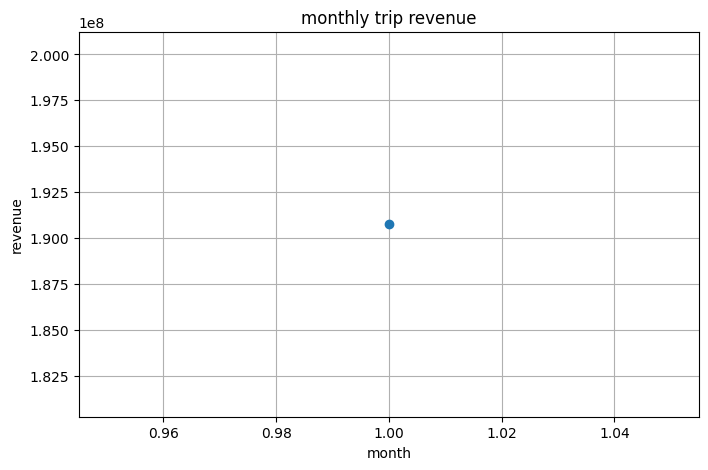

In [8]:
#plotted monthly revenue trend
plt.figure(figsize=(8,5))
plt.plot(
    monthly_revenue['pickup_month'],
    monthly_revenue['monthly_revenue'],
    marker='o'
)
plt.title('monthly trip revenue')
plt.xlabel('month')
plt.ylabel('revenue')
plt.grid(True)
plt.show()


^ Single data point as I've only imported one month's dataset, 2015-01.

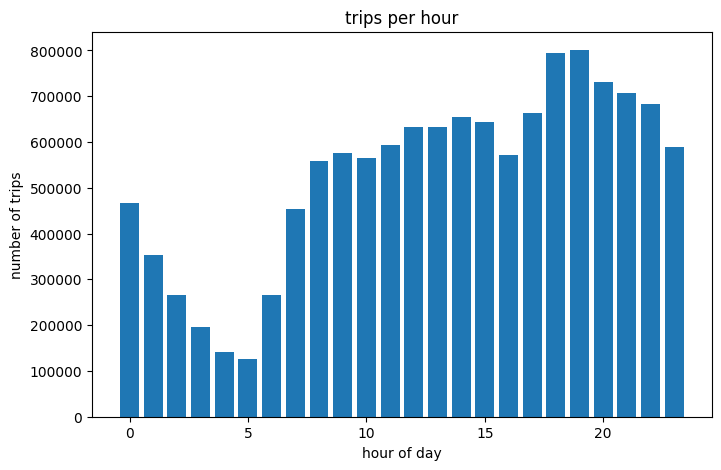

In [9]:
#plotted trips per hour
plt.figure(figsize=(8,5))
plt.bar(
    trips_per_hour['pickup_hour'],
    trips_per_hour['trip_count']
)
plt.title('trips per hour')
plt.xlabel('hour of day')
plt.ylabel('number of trips')
plt.show()


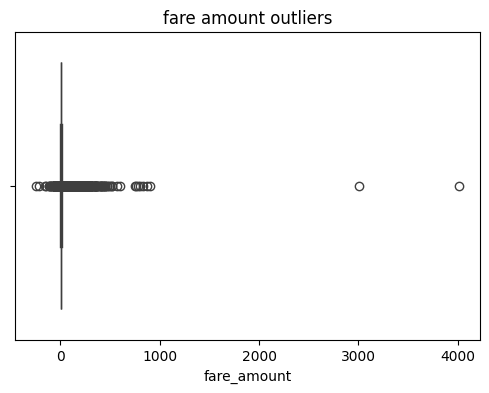

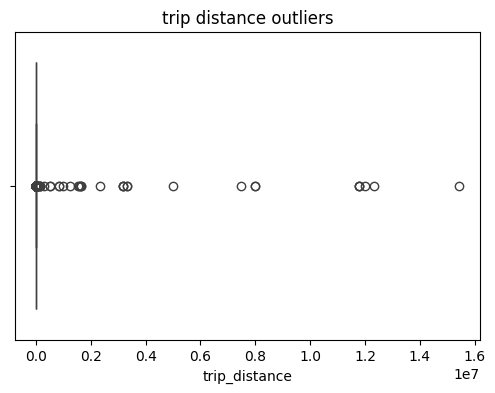

In [10]:
#fare outliers
plt.figure(figsize=(6,4))
sns.boxplot(x=df['fare_amount'])
plt.title('fare amount outliers')
plt.show()

#trip distance outliers
plt.figure(figsize=(6,4))
sns.boxplot(x=df['trip_distance'])
plt.title('trip distance outliers')
plt.show()


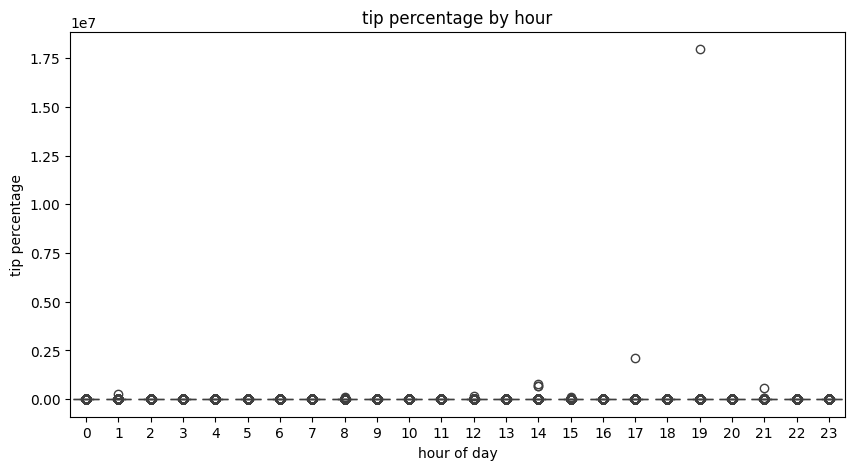

In [11]:
#tip distribution by hour
plt.figure(figsize=(10,5))
sns.boxplot(
    x='pickup_hour',
    y='tip_percentage',
    data=df
)
plt.title('tip percentage by hour')
plt.xlabel('hour of day')
plt.ylabel('tip percentage')
plt.show()


In [ ]:
#tip percentage per trip, without outliers
df['tip_percentage'] = np.where(
    df['fare_amount'] > 0,
    (df['tip_amount'] / df['fare_amount']) * 100,
    0
)


df_filtered_tips = df[(df['tip_percentage'] > 0) & (df['tip_percentage'] <= 100)]

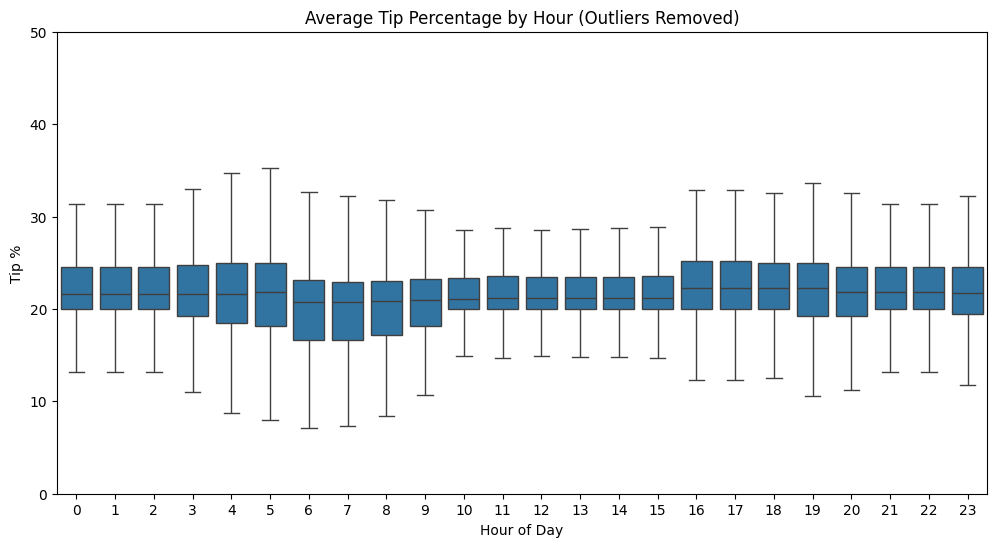

In [ ]:
#tip distribution by hour (using the filtered data)
plt.figure(figsize=(12,6))
sns.boxplot(
    x='pickup_hour', 
    y='tip_percentage', 
    data=df_filtered_tips,
    showfliers=False 
)
plt.title('Average Tip Percentage by Hour (Outliers Removed)')
plt.xlabel('Hour of Day')
plt.ylabel('Tip %')
plt.ylim(0, 50) 
plt.show()